<a href="https://colab.research.google.com/github/hamagami/is2024/blob/main/is05_nonlinear_SVM_classification_with_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05_nonlinear_SVM_classification_with_scratch

In [1]:
import numpy as np
from scipy.optimize import minimize
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [2]:

class SVM:
    def __init__(self, kernel='rbf', C=1.0, gamma=0.5):
        self.C = C  # Regularization parameter
        self.kernel = kernel
        self.gamma = gamma  # Parameter for RBF kernel
        self.alpha = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None
        self.b = None

    def rbf_kernel(self, x, y):
        return np.exp(-self.gamma * np.linalg.norm(x - y) ** 2)

    def linear_kernel(self, x, y):
        return np.dot(x, y)

    def compute_kernel_matrix(self, X):
        m = X.shape[0]
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                if self.kernel == 'rbf':
                    K[i, j] = self.rbf_kernel(X[i], X[j])
                elif self.kernel == 'linear':
                    K[i, j] = self.linear_kernel(X[i], X[j])
        return K

    def fit(self, X, y):
        m, n = X.shape
        K = self.compute_kernel_matrix(X)

        # Objective function for dual form
        def objective(alpha):
            return 0.5 * np.sum(alpha * alpha * K * y[:, None] * y[None, :]) - np.sum(alpha)

        # Constraints
        cons = ({'type': 'eq', 'fun': lambda alpha: np.dot(alpha, y)},
                {'type': 'ineq', 'fun': lambda alpha: self.C - alpha},
                {'type': 'ineq', 'fun': lambda alpha: alpha})

        # Initial guess for alpha
        alpha_init = np.zeros(m)

        # Solve QP problem
        result = minimize(objective, alpha_init, constraints=cons)
        self.alpha = result.x

        # Support vectors
        support_vector_indices = self.alpha > 1e-5
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]
        self.support_vector_alphas = self.alpha[support_vector_indices]

        # Compute intercept
        self.b = np.mean([
            y_k - np.sum(self.support_vector_alphas * self.support_vector_labels * K[support_vector_indices, k])
            for k, y_k in enumerate(self.support_vector_labels)
        ])

    def decision_function(self, X):
        K = np.array([[self.rbf_kernel(x, sv) for sv in self.support_vectors] for x in X])
        return np.dot(K, self.support_vector_alphas * self.support_vector_labels) + self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

In [14]:
# Generate a dataset (non-linearly separable)
X, y = make_moons(n_samples=100, noise=0.1, random_state=1)
y = np.where(y == 0, -1, 1)  # Convert labels to -1 and 1

# Train the SVM
 #By changing the kernel and values of C and gamma the results will vary in different.
svm = SVM(kernel='rbf', C=0.5, gamma=3.0)
svm.fit(X, y)

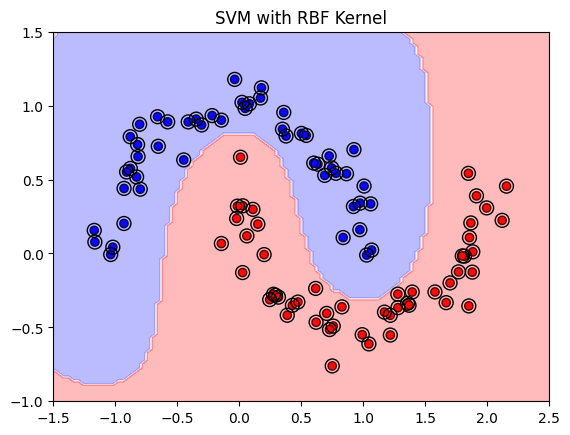

In [15]:
# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', marker='o', edgecolor='k')
xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.0, 1.5, 100))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1], s=100, facecolors='none', edgecolors='k')
plt.title("SVM with RBF Kernel")
plt.show()
